In [1]:
import pandas as pd
import os, re

In [2]:
# Specify the experiment type, i.e., 0: load stimulus, 1: resource stimulus
exp_type = 0

In [3]:
# Change the work directory to the parent
try:
    if chdir:
        pass
except:
    current_dir = os.getcwd()
    os.chdir(current_dir +"/..")
    os.path.abspath(os.curdir)

In [4]:
chdir = True

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 11})

plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 300

In [6]:
# Metadata for specific SFC configurations
exp_ls = "freq_exp"
exp_rs = "exp-4-1-1"
vnfs = ["firewall.csv", "nf_router.csv", "ndpi_stats.csv", "payload_scan.csv", "bridge.csv"]

In [7]:
def parse_seq(exp_type, exp_num, file, index=5):
    "Parse sequential data, specialized for the TX/RX/Latency experiments"
    tmp = []
    
    if file.startswith("latency.csv"):
        with open(os.path.join(exp_type, exp_num, file)) as f:
            lines = f.readlines()[4:] if exp_type == "load_stimulus" else f.readlines()
            for line in lines:
                tmp.append(float(line.strip())/1000)
    else:
        with open(os.path.join(exp_type, exp_num, file)) as f:
            next(f)
            for l in f:
                tmp.append(float(l.strip().split(",")[index]))
                
    return tmp

In [8]:
def parse_reg(exp_type, exp_num, file, stat_name, index=1):
    "Parse the Perf data"
    stat = []
    with open(os.path.join(exp_type, exp_num, file)) as file:
        for line in file:
            if re.search(stat_name, line):
                stat.append(line.strip().split(',')[index])
    
    return list(map(lambda x:float(x), stat[:-1]))

In [9]:
latency = parse_seq("load_stimulus", exp_ls, "latency.csv")
len(latency)

906

In [10]:
tx_stats = parse_seq("load_stimulus", exp_ls, "tx_stats.csv")
len(tx_stats)

899

In [11]:
rx_stats = parse_seq("load_stimulus", exp_ls, "rx_stats.csv")
len(rx_stats)

899

In [12]:
firewall_instructions = parse_reg("load_stimulus", exp_ls, "firewall.csv", "instructions", 1)
len(firewall_instructions)

902

In [13]:
features = ["instructions", "branches,", "branch-misses,", "branch-load-misses,", "cache-misses", \
            "cache-references", ",cycles,", "L1-dcache-load-misses", "L1-dcache-loads", "LLC-load-misses", \
            "LLC-stores", "LLC-loads",]

In [14]:
def make_df():
    tmp = []
    dic = dict()
    
    tx_stats = parse_seq("load_stimulus", exp_ls, "tx_stats.csv")
    rx_stats = parse_seq("load_stimulus", exp_ls, "rx_stats.csv")
    
    latency = parse_seq("load_stimulus", exp_ls, "latency.csv")
    #normalized_latency = []
    #for i in range(0, len(latency)):
        #if i % 2:
            #normalized_latency.append(latency[i])
    
    seq_length = min([len(parse_reg("load_stimulus", exp_ls, "firewall.csv", "instructions", 1)), \
                          len(tx_stats), \
                          len(rx_stats), \
                          len(latency)])
    dic["input_rate"] = tx_stats[:seq_length]
    dic["output_rate"] = rx_stats[:seq_length]
    dic["latency"] = latency[:seq_length]
    
    for f in features:
        for v in vnfs:
            tmp = parse_reg("load_stimulus", exp_ls, v, f, 1)
            
            dic[v.split(".")[0]+"_"+f.replace(",","")] = tmp[:seq_length]
            
    return pd.DataFrame(dic)

In [15]:
df = make_df()
df

,input_rate,output_rate,latency,firewall_instructions,nf_router_instructions,ndpi_stats_instructions,payload_scan_instructions,bridge_instructions,firewall_branches,nf_router_branches,...,firewall_LLC-stores,nf_router_LLC-stores,ndpi_stats_LLC-stores,payload_scan_LLC-stores,bridge_LLC-stores,firewall_LLC-loads,nf_router_LLC-loads,ndpi_stats_LLC-loads,payload_scan_LLC-loads,bridge_LLC-loads
0,528.411851,488.863819,32.313,2.301652e+09,2.164174e+09,2.290415e+09,2.271882e+09,2.285761e+09,455169684.0,435420777.0,...,0.0,25.0,25.0,25.0,288.0,551.0,576.0,526.0,667.0,651.0
1,484.078349,528.052394,22.115,2.326688e+09,2.296317e+09,2.301890e+09,2.234927e+09,2.231073e+09,458232541.0,453110457.0,...,13.0,113.0,351.0,125.0,400.0,926.0,801.0,12090.0,3432.0,2102.0
2,528.118968,528.136094,12.400,2.315609e+09,2.019777e+09,2.168157e+09,2.220910e+09,2.192226e+09,442999187.0,411518827.0,...,338.0,688.0,326.0,826.0,1115.0,3419.0,4458.0,4034.0,6085.0,10711.0
3,528.222389,528.302500,49.680,2.322508e+09,2.301158e+09,2.293531e+09,2.294851e+09,2.314927e+09,457524895.0,453543407.0,...,75.0,25.0,25.0,50.0,50.0,689.0,715.0,714.0,839.0,889.0
4,528.393313,528.341873,93.881,2.326306e+09,2.222949e+09,2.303790e+09,2.223276e+09,2.237432e+09,458352349.0,442523636.0,...,67949.0,0.0,0.0,25.0,25.0,145717.0,538.0,601.0,1423.0,438.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
894,528.519091,528.358409,6.317,2.235648e+09,2.138907e+09,2.238519e+09,2.160910e+09,2.139766e+09,440527328.0,426032740.0,...,181687.0,217263.0,135858.0,129842.0,169084.0,325571.0,352423.0,250338.0,288349.0,305657.0
895,528.176200,528.236488,5.812,2.235768e+09,2.224976e+09,2.238581e+09,2.248184e+09,2.225345e+09,428244709.0,438249622.0,...,186225.0,210292.0,140942.0,126769.0,167538.0,318583.0,359943.0,277775.0,292991.0,304503.0
896,528.203444,528.222242,5.866,2.238407e+09,2.222500e+09,2.239541e+09,1.935714e+09,2.217148e+09,441073905.0,438037289.0,...,183283.0,222359.0,137959.0,133178.0,168044.0,319452.0,351690.0,250855.0,287074.0,314441.0
897,528.451592,528.417521,6.247,2.236118e+09,2.134266e+09,2.230312e+09,2.100404e+09,2.129860e+09,440748092.0,425057742.0,...,184113.0,223379.0,138934.0,133519.0,171465.0,327406.0,361059.0,252526.0,290175.0,319545.0


<AxesSubplot:>

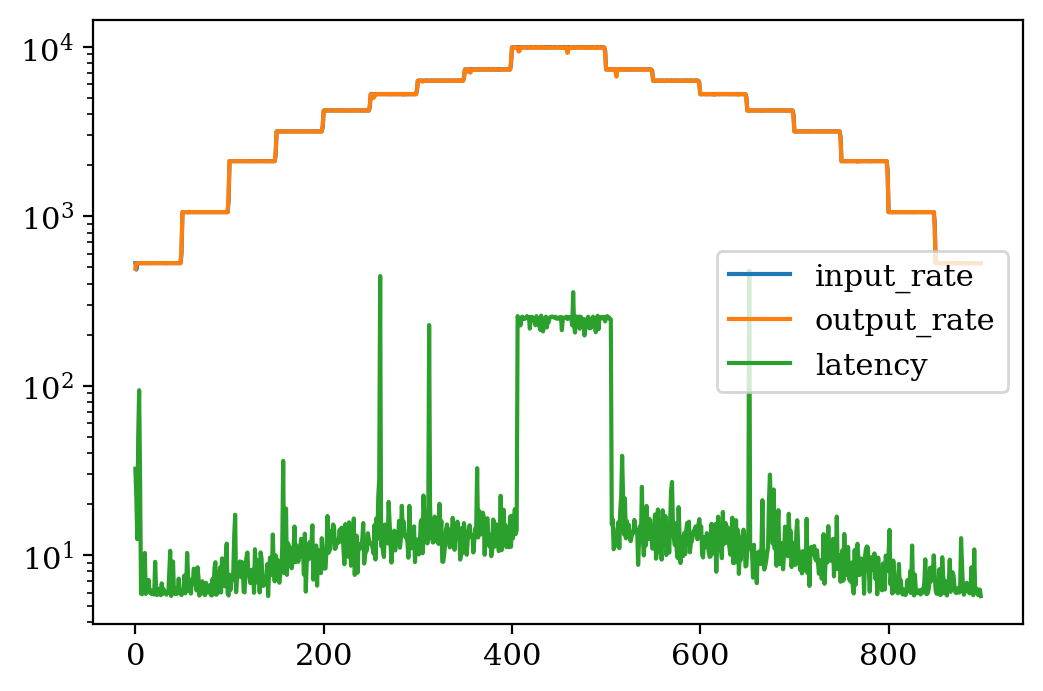

In [16]:
df.iloc[:, :3].plot(logy=True)

In [17]:
df.to_csv("load_stimulus_"+ exp_ls +".csv", sep=',')